In [ ]:
! pip install sentence_transformers
! pip install konlpy

In [ ]:
! git clone https://github.com/theeluwin/sci-news-sum-kr-50.git
! mv sci-news-sum-kr-50/data ./
! rm -r sci-news-sum-kr-50/

In [ ]:
import json
from collections import defaultdict

def merge_dict(dicts):
    merged_dict = defaultdict(list)
    for d in dicts:
        for k,v in d.items():
            merged_dict[k].append(v)
    return merged_dict

dicts = [json.load(open(f'data/{"0"+str(i) if i<10 else i}.json', 'r')) for i in range(1, 51)]
data = merge_dict(dicts)

# 0. Data Structure

50개의 IT-과학 분야 뉴스 기사 + 요약 문장

- title: `str` = 기사 제목
- source: `str`= 기사 출처 url
- length: `int` = 기사 내 문장 개수
- summaries: `List[int]` = 기사 내 요약문으로 쓰일 수 있는 문장 인덱스
- sentences: `List[str]` = 기사의 내용 (list of sentences)

`data`는 50개 기사에 대한 정보를 모두 합친 dictonary이다.  
즉, data['title']은 50개의 title을 담고 있는 `list`이다.

In [ ]:
idx =      10# @param {type: "number"}
print('title: \n' + data['title'][idx])
print('-----------------------')
print('content: \n' + '\n'.join(data['sentences'][idx]))
print('-----------------------')
print('summaries: \n' + '\n'.join([data['sentences'][idx][s] for s in data['summaries'][idx]]))

title: 
'고양이 눈' 학습한 AI 드론이 실종자 찾는다
-----------------------
content: 
'나선형 신경망' 학습 기술
카메라로 찍은 이미지에서 특정한 사물 찾는 기술 활용
숲속에서 등산로 척척 찾아 드론이 산악구조대 역할도
미국 국방부는 지난달 말 인공지능(AI)을 이용해 인간 도움 없이 적을 식별해 타격하는 드론(무인 항공기)을 시연했다
이 드론은 카메라 화면에서 총으로 무장한 사람과 무기가 없는 사람을 구분할 수 있다
표적으로 정한 사람을 찾아 그가 탄 자동차를 추적하는 기능도 있다
조만간 원격 조종 없이도 전장에서 특수부대 군인들처럼 임무를 수행하는 드론이 등장할 전망이다
이 드론이 사람 도움 없이 카메라 영상에서 목표물을 인식하고 추적할 수 있는 것은 바로 ‘머신러닝’ 덕분이다
머신러닝은 AI의 한 분야로 컴퓨터가 인간처럼 스스로 학습할 수 있는 능력을 부여하는 작업을 말한다
머신러닝의 원리는 인간을 포함한 영장류 두뇌의 정보 처리 구조인 ‘신경망’을 모사하는 방식이다
바둑 대결에서 이세돌 9단을 이긴 구글의 ‘알파고’ 등 지금까지 소개된 AI 대부분은 심층신경망을 기반으로 한 머신러닝 알고리즘을 이용한다
이미지에서 특정 사물을 찾는 기술은 인간이 아니라 고양이 뇌에서 유래했다
고양이 뇌의 시신경에서 발견되는 ‘나선형 신경망’ 구조는 시각세포들이 보내오는 반응을 모아 여러 개의 층(層)으로 나눈다
이를 3단계에 걸쳐 점차적으로 단순화하면서 물체의 색깔이나 모양을 파악한다
이를 처음으로 연구한 데이비드 휴벨과 토어스텐 비젤은 1981년 노벨 생리의학상을 받았다
AI 과학자들은 나선형 신경망에서 아이디어를 얻어 이미지에서 사물을 판별하는 알고리즘을 설계했다
우선 이미지에서 큰 특징을 추출한 다음 점차 작고 복잡한 특징을 발견해 나가는 방식이다
예컨대 사진 속에 자동차가 있다고 해 보자
알고리즘은 우선 사물의 전체적인 윤곽을 먼저 확인한 뒤 기존에 입력된 사진 데이터와 비교해 ‘탈 것’으로 범위를 좁힌다
이후 타이어나 제조사

! Note !

content와 summaries의 문장 개수가 모두 다르다.

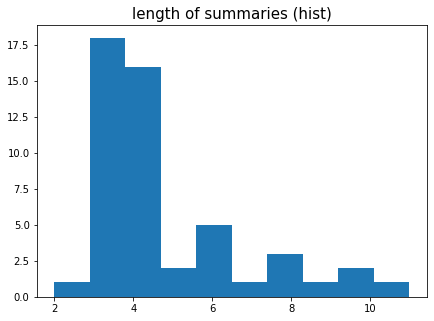

max length: 11
min length: 2
mean length: 4.62


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.title('length of summaries (hist)', size=15)
plt.hist(list(map(len, data['summaries'])))
plt.show()

print(f'max length: {max(list(map(len, data["summaries"])))}')
print(f'min length: {min(list(map(len, data["summaries"])))}')
print(f'mean length: {sum(list(map(len, data["summaries"])))/50}')

# 1. Data Preprocessing

## 1.1 명사형 토큰만 뽑아내기

- okt tokenizer를 이용해 명사 토큰만 분리

> okt의 성능이 결과에 미치는 영향이 클 것이다.

In [ ]:
import numpy as np

from konlpy.tag import Okt

In [ ]:
okt = Okt()
tokenized_sents = [
                   ' '.join(word for word, pos in okt.pos('. '.join(sent_list)) if pos == 'Noun') 
                   for sent_list in data['sentences']
]

In [ ]:
tokenized_sents[idx]

'나선형 신경망 학습 기술 카메라 이미지 사물 기술 활용 숲속 등산로 척척 드론 산악 구조대 역할 미국 국방부 지난달 말 인공 지능 이용 인간 도움 적 식별 타격 드론 무인 항공기 시연 이 드론 카메라 화면 총 무장 사람과 무기 사람 분할 수 표적 정 사람 그 자동차 추적 기능 조만간 원격 조종 전장 특수부대 군인 임무 수행 드론 등장 전망 이 드론 사람 도움 카메라 영상 목표 물 인식 추적 수 것 바로 머신 러닝 덕분 머신 러닝 의 분야 컴퓨터 인간 스스로 학습 수 능력 부여 작업 말 머신 러닝 원리 인간 포함 영장류 두뇌 정보 처리 구조 신경망 모사 방식 바둑 대결 이세돌 단 구글 알파 등 지금 소개 대부분 심층 신경망 기반 머신 러닝 알고리즘 이용 이미지 특정 사물 기술 인간 고양이 뇌 유래 고양이 뇌 시신경 발견 나선형 신경망 구조 세포 반응 여러 개 층 단계 점차 단순화 물체 색깔 모양 파악 처음 연구 데이비드 벨 토어스텐 비젤 노벨 생리 의학상 과학자 나선형 신경망 아이디어 이미지 사물 판별 알고리즘 설계 우선 이미지 특징 추출 다음 점차 작고 특징 발견 방식 사진 속 자동차 해 알고리즘 우선 사물 전체 윤곽 먼저 확인 뒤 기존 입력 사진 데이터 비교 탈 것 범위 이후 타이어 조사 엠블럼 세부 특징 파악 사진 속 물체 자동차 결론 제프 딘 구글 연구원 나선형 신경망 다른 머신 러닝 구조 비교 때 영상 음성 분야 성능 며 이용 컴퓨터 처음 사물 무엇 파악 수 고 설명 주변 볼 수 영상 촬영 용 드론 이 기술 이용 세계 위 드론 업체 중국 의 팬텀 사람 눈 두 개 카메라 센서 장 통해 대상 물체 확인 일정 거리 유지 액티브 트랙 기능 액티브 트랙 기능 이용자 지정 사물 사람 윤곽 선 인식 픽셀 이미지 구성 가장 단위 네모 모양 점 단위 인식 그 픽셀 계속 크기 유지 위해 기체 이동 주변 사람 지정 때 픽셀 크기 상하좌우 픽셀 해 그 사람 앞 움직 픽셀 크기 원래 수치 픽셀 위해 드론 따라서 앞 방식 과학자 나선형 신경망 머신 러닝 기술 응용 인간 삶 윤

## 1.2 키워드 후보 추출


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

key_candidates = []
for sent in tokenized_sents:
    vectorizer = CountVectorizer(ngram_range=(2,3)).fit([sent])     # CountVectorizer는 default로 2글자 이상의 단어만 사용한다.
    key_candidates.append(vectorizer.get_feature_names_out())

In [ ]:
print(f'sample: {key_candidates[idx][:5]}')

sample: ['가능 범위' '가능 범위 무궁무진' '가장 단위' '가장 단위 네모' '감지 장애물']


# 2. Modeling

S-BERT를 사용해서 본문과 가장 similarity가 높은 keyword candidate를 선택한다.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [ ]:
doc_embeddings = model.encode(['. '.join(doc_sents) for doc_sents in data['sentences']])
candidate_embeddings = [model.encode(candidates) for candidates in key_candidates]

In [ ]:
import time
candidate_embeddings = []

for i, candidates in enumerate(key_candidates, start=1):
    t0 = time.time()
    print(f'encoding - {i}\t delta= ', end='')
    candidate_embeddings.append(model.encode(candidates))
    print(':'.join(map(str, divmod(round(time.time()-t0), 60))))

encoding - 1	 delta= 0:11
encoding - 2	 delta= 0:6
encoding - 3	 delta= 0:9
encoding - 4	 delta= 0:14
encoding - 5	 delta= 0:8
encoding - 6	 delta= 0:3
encoding - 7	 delta= 0:7
encoding - 8	 delta= 0:7
encoding - 9	 delta= 0:23
encoding - 10	 delta= 0:10
encoding - 11	 delta= 0:18
encoding - 12	 delta= 0:4
encoding - 13	 delta= 0:8
encoding - 14	 delta= 0:5
encoding - 15	 delta= 0:4
encoding - 16	 delta= 0:5
encoding - 17	 delta= 0:15
encoding - 18	 delta= 0:7
encoding - 19	 delta= 0:6
encoding - 20	 delta= 0:17
encoding - 21	 delta= 0:7
encoding - 22	 delta= 0:4
encoding - 23	 delta= 0:13
encoding - 24	 delta= 0:10
encoding - 25	 delta= 0:13
encoding - 26	 delta= 0:5
encoding - 27	 delta= 0:7
encoding - 28	 delta= 0:5
encoding - 29	 delta= 0:9
encoding - 30	 delta= 0:19
encoding - 31	 delta= 0:11
encoding - 32	 delta= 0:12
encoding - 33	 delta= 0:14
encoding - 34	 delta= 0:4
encoding - 35	 delta= 0:9
encoding - 36	 delta= 0:28
encoding - 37	 delta= 0:16
encoding - 38	 delta= 0:8
encod

In [ ]:
print(f'doc_embeddings shape: {doc_embeddings.shape}')
print(f'candidaate embeddings length: {len(candidate_embeddings)}')
print(f'candidaate embeddings shape: {[embeddings.shape for embeddings in candidate_embeddings[:5]]}')

## 2.1 Similarity Strategy

### 2.1.1 cosine rank
cos-similarity를 구해서 top n개를 ranking 하는 방법

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_rank(doc_idx, top_n):
    """
    doc_embedding: 1개의 document에 대한 embedding, shape: (1, emb_dim)
    candidate_embeddings: 1개의 document에 대한 candidates의 embedding, shape: (n_candidates, emb_dim)
    """
    doc_emb = doc_embeddings[[doc_idx]]
    cand_embs = candidate_embeddings[doc_idx]

    distances = -cosine_similarity(doc_emb, cand_embs)
    keywards = [key_candidates[doc_idx][arg] for arg in distances.argsort()[0, :top_n]]

    return keywards

In [ ]:
cosine_rank(idx, 5)

['식별 타격 드론', '시연 드론 카메라', '개발 드론 카메라', '드론 카메라 촬영', '식별 확률 드론']

### 2.1.2 Max Sum Similarity

document와의 유사도는 최대화 하면서 candidates 간의 유사도는 최소화

In [34]:
from itertools import combinations as comb

def max_sum_similarity(doc_idx, top_n, grab_size):
    doc_emb = doc_embeddings[[doc_idx]]
    cand_embs = candidate_embeddings[doc_idx]

    doc_cand_distances = -cosine_similarity(doc_emb, cand_embs)
    cand_cand_distances = -cosine_similarity(cand_embs)

    # grep candidates
    grabbed_candidates_idx = doc_cand_distances.argsort()[0, :grab_size].tolist()
    
    # pick top_n candidates with smallest sum of similarity
    min_sim = np.inf
    candidate = None
    for cand_idx in comb(grabbed_candidates_idx, top_n):
        sim = sum([cand_cand_distances[i,j] for i,j in comb(cand_idx, 2)])
        if sim < min_sim:
            candidate = cand_idx
            min_sim = sim
    
    keywords = [key_candidates[doc_idx][arg] for arg in candidate]
    return keywords

In [ ]:
max_sum_similarity(idx, 5, 10)

['시연 드론 카메라', '드론 카메라 촬영', '드론 기술 이용', '촬영 드론 기술', '드론 카메라 화면']

### 2.1.3 Maximal Marginal Relevance

In [28]:
def mmr(doc_idx, top_n, diversity):
    doc_emb = doc_embeddings[[doc_idx]]
    cand_embs = candidate_embeddings[doc_idx]

    cand_doc_distances = -cosine_similarity(cand_embs, doc_emb)
    cand_cand_distances = -cosine_similarity(cand_embs)

    # 키워드로 뽑힌 토큰의 index
    keywords_idx = [np.argmin(cand_doc_distances)]
    # 키워드로 뽑히지 않은 후보의 index
    candidates_idx = [i for i in range(len(cand_embs)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # 후보들의 doc과의 similarity
        candidate_sim = cand_doc_distances[candidates_idx]
        # 각 후보들과 키워드 사이의 가장 큰 similarity
        target_sim = np.min(cand_cand_distances[candidates_idx][:, keywords_idx], axis=1)

        # doc과의 similarity와 keyword과의 similarity(negative)의 조화평균
        mmr_val = (1-diversity) * candidate_sim - diversity * target_sim.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmin(mmr_val)]

        keywords_idx.append(mmr_idx)
        candidates_idx.append(mmr_idx)

    keywords = [key_candidates[doc_idx][arg] for arg in keywords_idx]
    
    return keywords

In [ ]:
_ = [print(mmr(idx, 5, i/10)) for i in range(7)]

['식별 타격 드론', '시연 드론 카메라', '개발 드론 카메라', '드론 카메라 촬영', '식별 확률 드론']
['식별 타격 드론', '시연 드론 카메라', '개발 드론 카메라', '식별 확률 드론', '드론 카메라 촬영']
['식별 타격 드론', '개발 드론 카메라', '세계 드론 업체', '식별 확률 드론', '시연 드론 카메라']
['식별 타격 드론', '개발 드론 카메라', '세계 드론 업체', '학습 이후 드론', '식별 확률 드론']
['식별 타격 드론', '기술 활용 숲속', '드론 업체 중국', '개발 드론 카메라', '사진 자동차 알고리즘']
['식별 타격 드론', '등산로 사진', '사진 자동차 알고리즘', '기술 활용 숲속', '드론 업체 중국']
['식별 타격 드론', '등산로 사진', '인간 스스로 학습', '방식 사진 자동차', '고양이 시신경']


# Small Challenge

- sample1.txt 파일 내의 문단들의 키워드를 추출하기

## Make Input

In [19]:
import re

with open('sample1.txt', 'r') as f:
    docs = f.read()

docs = re.split(r'</br>\n?', docs)
docs

['All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.',
 'Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status. Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.',
 'All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.']

## Make Keyword Candidates

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

key_candidates = []

for doc in docs:
    vectorizer = CountVectorizer(ngram_range=(2,3)).fit([doc])
    key_candidates.append(vectorizer.get_feature_names_out())

## Make Model

In [35]:
import numpy as np
from sentence_transformers import SentenceTransformer

pretrained_model_name = "sentence-transformers/all-mpnet-base-v2"

model = SentenceTransformer(pretrained_model_name)

In [23]:
doc_embeddings = model.encode(docs)

In [24]:
import time
candidate_embeddings = []

for i, candidates in enumerate(key_candidates, start=1):
    t0 = time.time()
    print(f'encoding - {i}\t delta= ', end='')
    candidate_embeddings.append(model.encode(candidates))
    print(':'.join(map(str, divmod(round(time.time()-t0), 60))))

encoding - 1	 delta= 0:2
encoding - 2	 delta= 0:7
encoding - 3	 delta= 0:2


## Calculate Similarity

In [38]:
idx =    2# @param = {type: "number"}

print(f'document: \n{docs[idx]}')
print('-----------------')
print(f'keywords: (cosine ranking)\n{cosine_rank(idx, top_n=3)}')
print(f'keywords: (max sum similarity)\n{max_sum_similarity(idx, top_n=3, grab_size=6)}')
print(f'keywords: (cosine ranking)\n{mmr(idx, top_n=3, diversity=0.3)}')

document: 
All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.
-----------------
keywords: (cosine ranking)
['equal protection of', 'equal protection against', 'discrimination to equal']
keywords: (max sum similarity)
['equal protection of', 'equal protection against', 'equal protection']
keywords: (cosine ranking)
['equal protection of', 'discrimination to equal', 'this declaration and']


사실, sample1.txt 는 세계인권선언 (Universal Delaration of Human Rights)의 
- Article-1  
모든 인간은 태어날 때부터 자유로우며 그 존엄과 권리에 있어 동등하다. 인간은 천부적으로 이성과 양심을 부여받았으며 서로 형제애의 정신으로 행동하여야 한다.
- Article-2   
모든 사람은 인종, 피부색, 성, 언어, 종교, 정치적 또는 기타의 견해, 민족적 또는 사회적 출신, 재산, 출생 또는 기타의 신분과 같은 어떠한 종류의 차별이 없이, 이 선언에 규정된 모든 권리와 자유를 향유할 자격이 있다. 더 나아가 개인이 속한 국가 또는 영토가 독립국, 신탁통치지역, 비자치지역이거나 또는 주권에 대한 여타의 제약을 받느냐에 관계없이, 그 국가 또는 영토의 정치적, 법적 또는 국제적 지위에 근거하여 차별이 있어서는 아니 된다.
- Article-7  
모든 사람은 법 앞에 평등하며 어떠한 차별도 없이 법의 동등한 보호를 받을 권리를 가진다. 모든 사람은 이 선언에 위반되는 어떠한 차별과 그러한 차별의 선동으로부터 동등한 보호를 받을 권리를 가진다.


입니다.

# 코드 블록화

In [56]:
from itertools import combinations as comb
from sklearn.metrics.pairwise import cosine_similarity

def cosine_rank(doc_emb, cand_embs, top_n):
    """
    :param doc_embedding: 1개의 document에 대한 embedding, shape: (1, emb_dim)
    :param candidate_embeddings: 1개의 document에 대한 candidates의 embedding, shape: (n_candidates, emb_dim)
    :param top_n: keyword로 뽑을 단어의 수
    """
    distances = -cosine_similarity(doc_emb, cand_embs)
    keywords_idx = distances.argsort()[0, :top_n]

    return keywords_idx.tolist()


def max_sum_similarity(doc_emb, cand_embs, top_n, grab_size):
    """
    1. `grab_size` 만큼의 상위 candidates를 뽑는다.
    2. 그 중 가장 적은 유사도 합을 나타내는 `top_n`개의 단어 집합을 선택한다.

    :param doc_emb: 1개의 document에 대한 embedding, shape: (1, emb_dim)
    :param cand_embs: 1개의 document에 대한 candidates의 embbedding, shape: (n_candidates, emb_dim)
    :param top_n: keyword로 뽑을 단어의 수
    :param grab_size: 가장 서로 유사도가 적은 단어를 뽑기 위한 집합의 크기
    """
    doc_cand_distances = -cosine_similarity(doc_emb, cand_embs)
    cand_cand_distances = -cosine_similarity(cand_embs)

    # grep candidates
    grabbed_candidates_idx = doc_cand_distances.argsort()[0, :grab_size].tolist()
    
    # pick top_n candidates with smallest sum of similarity
    min_sim = np.inf
    candidate = None
    for cand_idx in comb(grabbed_candidates_idx, top_n):
        sim = sum([cand_cand_distances[i,j] for i,j in comb(cand_idx, 2)])
        if sim < min_sim:
            candidate = cand_idx
            min_sim = sim
    
    return list(candidate)

def mmr(doc_emb, cand_embs, top_n, diversity):
    """
    keyword candidate에 대해서, 본문과의 유사도(sim1)과 candidate간의 유사도(sim2)를 두고,
    sim1과 -sim2의 diversity에 대한 조화평균을 최대화 하는 keyword를 선택한다.
    :param doc_emb: 1개의 document에 대한 embedding, shape: (1, emb_dim)
    :param cand_embs: 1개의 document에 대한 candidates의 embbedding, shape: (n_candidates, emb_dim)
    :param top_n: keyword로 뽑을 단어의 수
    :param diversity: keyword의 다양성 factor
    """
    cand_doc_distances = -cosine_similarity(cand_embs, doc_emb)
    cand_cand_distances = -cosine_similarity(cand_embs)

    # 키워드로 뽑힌 토큰의 index
    keywords_idx = [np.argmin(cand_doc_distances)]
    # 키워드로 뽑히지 않은 후보의 index
    candidates_idx = [i for i in range(len(cand_embs)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # 후보들의 doc과의 similarity
        candidate_sim = cand_doc_distances[candidates_idx]
        # 각 후보들과 키워드 사이의 가장 큰 similarity
        target_sim = np.min(cand_cand_distances[candidates_idx][:, keywords_idx], axis=1)

        # doc과의 similarity와 keyword과의 similarity(negative)의 조화평균
        mmr_val = (1-diversity) * candidate_sim - diversity * target_sim.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmin(mmr_val)]

        keywords_idx.append(mmr_idx)
        candidates_idx.append(mmr_idx)

    return keywords_idx

def summarize(model: SentenceTransformer, doc: str, strategy: str = 'cosine_rank', **strategy_kwargs):
    vectorizer = CountVectorizer(ngram_range=(2,3)).fit([doc])
    key_candidates = vectorizer.get_feature_names_out()

    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(key_candidates)

    similarity_strategy = None
    if strategy == 'cosine_rank':
        similarity_strategy = cosine_rank
    elif strategy == 'max_sum_similarity':
        similarity_strategy = max_sum_similarity
    elif strategy == 'mmr':
        similarity_strategy = mmr
    else:
        raise ValueError(f'similarity stratege name unknown: {strategy}')
    
    keywords_idx = similarity_strategy(doc_embedding, 
                                       candidate_embeddings, 
                                       **strategy_kwargs)
    
    return [key_candidates[arg] for arg in keywords_idx]

In [57]:
doc = """Russia invaded Ukraine on 24 February 2022, marking a steep escalation of the Russo-Ukrainian War which had begun in 2014. The invasion has caused Europe's largest refugee crisis since World War II,[18][19] with more than 5.8 million Ukrainians leaving the country[20] and a quarter of the population displaced.[21][22]

At the start of the war in 2014, Russia annexed the south Ukrainian region of Crimea, and Russian-backed separatists seized part of the south-eastern regions of Ukraine (the Donbas; in Luhansk and Donetsk oblasts), sparking a regional war there.[23][24] In 2021, Russia began a large military build-up along its border with Ukraine, amassing up to 190,000 troops along with their equipment. In a televised address shortly before the invasion, Russian president Vladimir Putin espoused irredentist views,[25] questioned Ukraine's right to statehood,[26][27] and falsely[28] accused Ukraine of being governed by neo-Nazis who persecute the ethnic Russian minority.[29] Putin also said the North Atlantic Treaty Organization (NATO) constituted a threat to Russia's national security by having expanded eastward since the early 2000s, which NATO disputed.[30] Russia demanded NATO stop expanding and permanently bar Ukraine from ever joining the alliance.[31] Multiple nations accused Russia of planning to attack or invade Ukraine, which Russian officials repeatedly denied as late as 23 February 2022.[35]

On 21 February 2022, Russia recognised the Donetsk People's Republic and the Luhansk People's Republic, two self-proclaimed statelets in Donbas controlled by pro-Russian separatists.[36] The following day, the Federation Council of Russia authorised the use of military force abroad, and Russian troops overtly entered both territories.[37] The invasion began on the morning of 24 February,[38] when Putin announced a "special military operation" to "demilitarise and denazify" Ukraine.[39][40] Minutes later, missiles and airstrikes hit across Ukraine, including the capital Kyiv, shortly followed by a large ground invasion from multiple directions.[41][42] In response, Ukrainian president Volodymyr Zelenskyy enacted martial law and general mobilisation of all male Ukrainian citizens between the ages of 18 and 60, who were banned from leaving the country.[43][44]

As the invasion began on 24 February 2022, the northern front launched from Belarus towards Kyiv, with a northeastern front attack on the city of Kharkiv; the southeastern front was conducted as two separate spearhead fronts, including a southern front (originating in Crimea) and a separate probative southeastern front (launched at the cities of Luhansk and Donetsk).[45][46] On 8 April, the Russian ministry announced that all troops and divisions deployed in southeastern Ukraine would unite under General Aleksandr Dvornikov, who took charge of combined military operations, including the redeployed probative fronts originally assigned to the northern and north-eastern fronts, subsequently withdrawn and reassigned to the second phase on the southeastern front.[47] By 17 April, progress on the southeastern front was impeded by remaining troops continuing to hold out in the Azovstal iron and steel works in Mariupol.[48] On 19 April, Russia launched a renewed invasion across a 300-mile front extending from Kharkiv to Donetsk and Luhansk, with simultaneous missile attacks again directed at Kyiv in the north and Lviv in western Ukraine.[49]

The invasion was internationally condemned as an act of aggression.[50][51] A United Nations General Assembly resolution demanded a full withdrawal of Russian forces, the International Court of Justice ordered Russia to suspend military operations and the Council of Europe expelled Russia. Many countries imposed new sanctions, which have affected the economies of Russia and the world,[52] and provided humanitarian and military aid to Ukraine.[53] Protests occurred around the world; those in Russia were met with mass arrests and increased media censorship,[54][55] including banning the use of the words "war" and "invasion".[42] Numerous companies withdrew their products and services from Russia and Belarus, and Russian state-funded media were banned from broadcasting and removed from online platforms. The International Criminal Court opened an investigation into war crimes that occurred in Ukraine since the 2013–2014 Revolution of Dignity through to war crimes in the 2022 invasion.[56]"""

In [58]:
summarize(model, doc, strategy='cosine_sim', top_n=5)

['russia invaded ukraine',
 'invaded ukraine on',
 'invade ukraine which',
 'invaded ukraine',
 'invade ukraine']

In [59]:
summarize(model, doc, strategy='mmr', top_n=5, diversity=0.4)

['russia invaded ukraine',
 'the 2022 invasion',
 'border with ukraine',
 'russia national security',
 'ukraine amassing up']